<img src="https://www.th-koeln.de/img/logo.svg" style="float:right;" width="200">



# 10th exercise: <font color="#C70039"> Seasonal Autoregressive Integrated Moving Average model with exogenous variables - SARIMAX(p,d,q)(P,D,Q)_m: Economic Data Forecast </font>
* Course: <a href="https://www.gernotheisenberg.de/time_series_forecasting.html">Time Series Forecasting (TSF)</a>
* Lecturer: <a href="https://www.gernotheisenberg.de/uebermich.html">Gernot Heisenberg</a>
* Date:   18.03.2025

<img src="./images/sarimax.png" style="float: center;" width="450">

---------------------------------
**GENERAL NOTE 1**:
Please make sure you are reading the entire notebook, since it contains a lot of information on your tasks (e.g. regarding the set of certain paramaters or a specific computational trick), and the written mark downs as well as comments contain a lot of information on how things work together as a whole.

**GENERAL NOTE 2**:
* Please, when commenting source code, just use English language only.
* When describing an observation please use English language, too
* This applies to all exercises throughout this course.  

---------------------

### <font color="ce33ff">DESCRIPTION OF THE NOTEBOOK CONTENT</font>:
This notebook allows you for learning how to implement and apply the moste general version of a statistical model, the so-called Seasonal Autoregressive Integrated Moving Average model with exogenous variables of orders p, d and q SARIMA(p,d,q)(P,D,Q)_m.

-------------------------------------------------------------------------------------------------------------

### <font color="FFC300">TASKS</font>:
The tasks that you need to work on within this notebook are always indicated below as bullet points.
If a task is more challenging and consists of several steps, this is indicated as well.
Make sure you have worked down the task list and commented your doings.
This should be done by using markdown.<br>
<font color=red>Make sure you don't forget to specify your name and your matriculation number in the notebook.</font>

**YOUR TASKS in this exercise are as follows**:
1. import the notebook to Google Colab or use your local machine.
2. make sure you specified you name and your matriculation number in the header below my name and date.
    * set the date too and remove mine.
3. read the entire notebook carefully
    * add comments whereever you feel it necessary for better understanding
    * run the notebook for the first time.
    * understand the output
4. Use all exogenous variables in a SARIMAX model to predict the real GDP
    * Until now, we limited the number of exogenous variables when forecasting for the real GDP. 
    * This exercise is an opportunity to fit a SARIMAX model using all exogenous variables and to verify if you can achieve better performance.
    * Use all exogenous variables in the SARIMAX model.
    * Perform residual analysis.
    * Produce forecasts for the last seven timesteps in the data set.
    * Measure the MAPE. 
    * Is it better, worse or identical to what was achieved with a limited number of exogenous variables?

-----------------------------------------------------------------------------------

## 10.0 Module import

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 10.1 Data loading and visualization

Data source:
https://www.statsmodels.org/dev/datasets/generated/macrodata.html

In [10]:
# load data
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


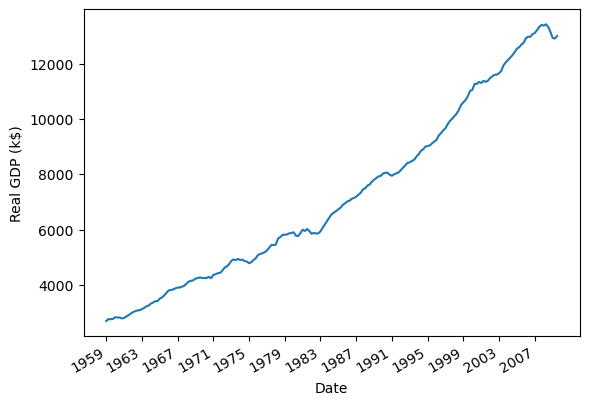

In [11]:
# visualize data
fig, ax = plt.subplots()

ax.plot(macro_econ_data['realgdp'])
ax.set_xlabel('Date')
ax.set_ylabel('Real GDP (k$)')

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.show()

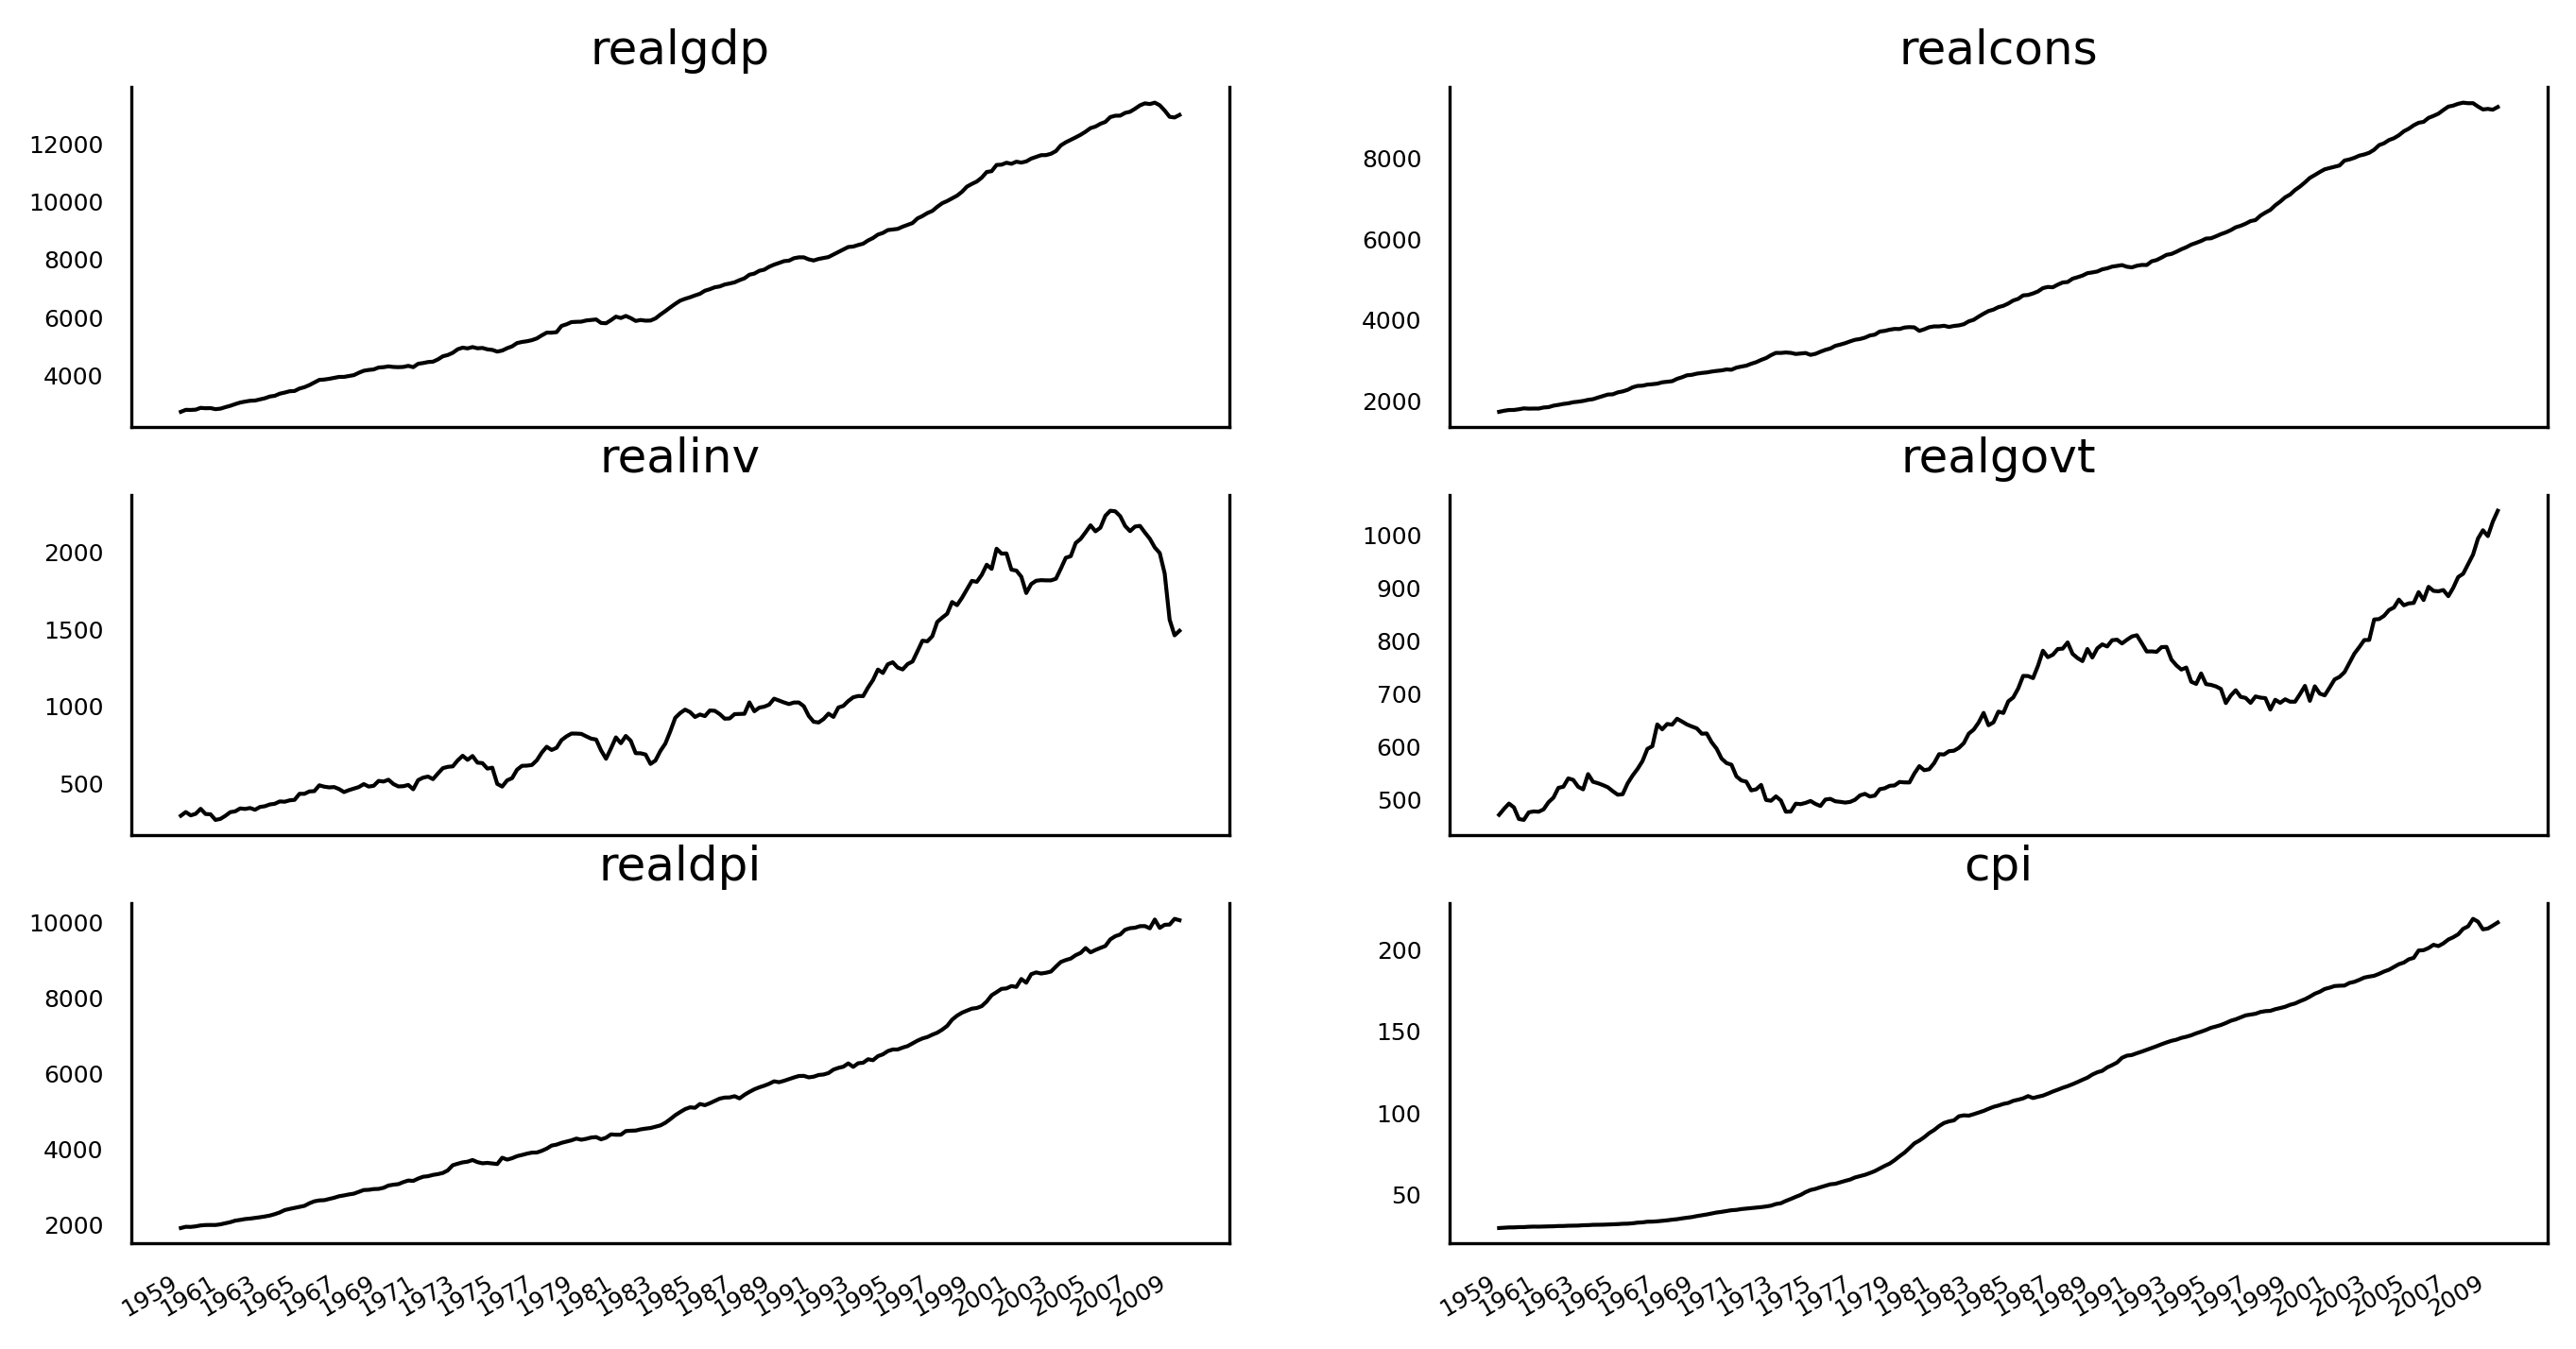

In [12]:
# visualize data
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=300, figsize=(11,6))

for i, ax in enumerate(axes.flatten()[:6]):
    data = macro_econ_data[macro_econ_data.columns[i+2]]

    ax.plot(data, color='black', linewidth=1)
    ax.set_title(macro_econ_data.columns[i+2])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.setp(axes, xticks=np.arange(0, 208, 8), xticklabels=np.arange(1959, 2010, 2))
fig.autofmt_xdate()
plt.show()

## 10.2 Augmented Dickey-Fuller test

In [13]:
target = macro_econ_data['realgdp']
exog = macro_econ_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi']]

In [6]:
ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 1.7504627967647104
p-value: 0.9982455372335032


In [7]:
target_diff = target.diff()

ad_fuller_result = adfuller(target_diff[1:])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -6.305695561658104
p-value: 3.327882187668259e-08


## 10.3 Optimizing the SARIMAX model

In [8]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

## 10.4 Model building and training

In [9]:
# Try values from 0 to 3, but feel free to try a different set of values on your own.
p = range(0, 4, 1)
d = 1 # see above
q = range(0, 4, 1)
P = range(0, 4, 1) # we expect this to be zero
D = 0 # there is no seasonality -> zero
Q = range(0, 4, 1) # we expect this to be zero
s = 4 # Since the data is collected quarterly, m = 4 (or) s = 4

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [10]:
target_train = target[:200]
exog_train = exog[:200]

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d, D, s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(3, 3, 0, 0)",1742.820882
1,"(3, 3, 1, 0)",1744.967503
2,"(3, 3, 0, 1)",1744.998574
3,"(2, 2, 0, 0)",1745.418286
4,"(2, 2, 0, 1)",1746.253253
...,...,...
251,"(0, 2, 0, 0)",1761.579044
252,"(0, 3, 0, 0)",1762.317095
253,"(0, 0, 0, 0)",1764.754980
254,"(1, 0, 0, 0)",1765.379412


In [11]:
best_model = SARIMAX(target_train, exog_train, order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                realgdp   No. Observations:                  200
Model:               SARIMAX(3, 1, 3)   Log Likelihood                -859.410
Date:                Mon, 05 May 2025   AIC                           1742.821
Time:                        17:29:10   BIC                           1782.341
Sample:                             0   HQIC                          1758.816
                                - 200                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9699      0.045     21.578      0.000       0.882       1.058
realinv        1.0136      0.033     30.782      0.000       0.949       1.078
realgovt       0.7283      0.127      5.738      0.0

#### <font color = red>INTERPRETATION:</font> 
The SARIMAX implementation in statsmodels comes with a regression analysis using the summary method.

In that analysis, we can see the p-value ( under column P>|z| ) associated with each coefficient of each predictor of the SARIMAX model. 

All exogenous variables have a p-value smaller than 0.05, except for realdpi, which has a p-value of 0.692. This means that the coefficient of realdpi is not significantly different from 0. Notice that its coefficient is 0.0099. However, the coefficient is kept in the model, as the p-value does not determine the relevance of this predictor in forecasting our target.

<font color = red>IMPORTANT NOTE:</font> 
Often the p-value is misused as a way to perform feature selection. 
Many data scientists incorrectly interpret the p-value as a way to determine if a predictor is correlated with the target.
In fact, the p-value tests whether the coefficient is significantly different from 0 or not. If the p-value is less than 0.05, then we reject the null hypothesis and conclude that
the coefficient is significantly different from 0. It does not determine whether a predictor is useful for forecasting.
Therefore, you should not remove predictors based on their p-values. Selecting the model by minimizing the AIC takes care of that step.

To learn more, additionally read Rob Hyndman’s “Statistical tests for variable selection”: https://robjhyndman.com/hyndsight/tests2/.

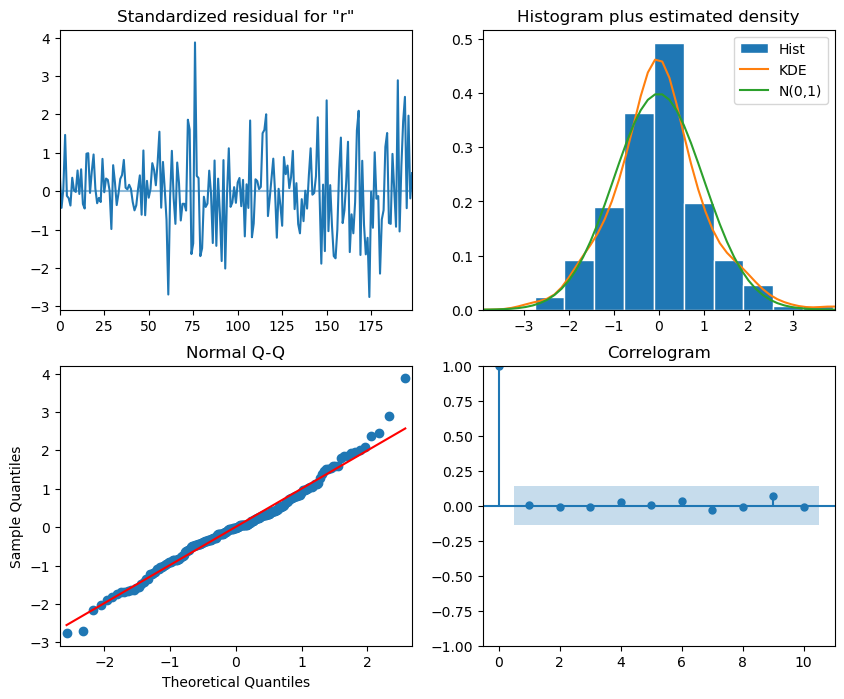

In [12]:
best_model_fit.plot_diagnostics(figsize=(10,8))
plt.show()

In [13]:
residuals = best_model_fit.resid

lb_value = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(lb_value)

     lb_stat  lb_pvalue
1   0.092280   0.761298
2   0.204045   0.903009
3   0.206715   0.976498
4   1.237704   0.871853
5   1.238809   0.941100
6   1.263748   0.973619
7   1.458705   0.983705
8   1.468984   0.993211
9   1.840068   0.993752
10  1.846150   0.997389


#### RESULTS
the residual analysis of the selected model show qualitatively that the residuals have no trend and a fairly constant variance over time, just like white noise. 
In the top-right plot, the distribution of residuals is very close to a normal distribution. This is further supported by the Q-Q plot at the bottom left, 
which shows a fairly straight line that lies on y = x. Finally, the correlogram shows no significant coefficients after lag 0, just like white noise.
Therefore, from the graphical analysis point of view, the residuals of this model resemble white noise.

Also the Ljung-Box test supports this result: All the p-values are greater than 0.05. Therefore, we do not reject the null hypothesis and we conclude that the residuals are independent and uncorrelated. 

Having passed both residual checks, the model can be used for forecasting.

## 10.5 Forecasting

As mentioned before, the caveat of using a SARIMAX model is that it is reasonable to predict only the next timestep, to avoid predicting the exogenous variables as well,
which would lead us to accumulate prediction errors in the final forecast. 

Instead, to test the model, predict the next timestep multiple times and average the errors of each prediction. 
This is done using the rolling_forecast function, which you worked with earlier already. 

As a baseline model, use the last known value method. 

In [14]:
# define a function to conduct a recursive forecast
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    # baseline model
    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value
    
    # our stastistical model
    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog[:i], exog[:i], order=(3,1,3), seasonal_order=(0,0,0,4), simple_differencing=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)

        return pred_SARIMAX

In [15]:
# compare predictions
target_train = target[:196]
target_test = target[196:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1 # only predict one time frame

pred_last_value = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_SARIMAX = recursive_forecast(target, exog, TRAIN_LEN, HORIZON, WINDOW, 'SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

,actual,pred_last_value,pred_SARIMAX
196,13366.865,13391.249,13344.064982
197,13415.266,13366.865,13373.510385
198,13324.600,13415.266,13378.807882
199,13141.920,13324.600,13327.772921
200,12925.410,13141.920,13133.361469
201,12901.504,12925.410,12886.620223
202,12990.341,12901.504,12873.793147


In [16]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [17]:
mape_last    = mape(pred_df.actual, pred_df.pred_last_value)
mape_SARIMAX = mape(pred_df.actual, pred_df.pred_SARIMAX)

print(mape_last, mape_SARIMAX)

0.736849498653785 0.7034659157509774


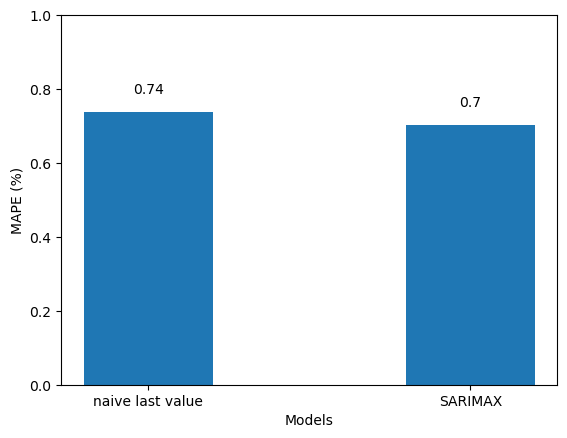

In [18]:
# create bar plots
fig, ax = plt.subplots()

x = ['naive last value', 'SARIMAX']
y = [mape_last, mape_SARIMAX]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 1)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
plt.show()

#### RESULTS

The mean absolute percentage error (MAPE) of the forecasts of each method. You can see that the SARIMAX model only has a slightly smaller MAPE than
the baseline. This highlights the importance of using a baseline, as a MAPE of 0.70% is extremely good, but a naive forecast achieves a MAPE of 0.74%, meaning that the
SARIMAX model only has a small advantage.